In [1]:
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
import tensorflow.contrib.eager as tfe
from functools import partial
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import matplotlib.tri as tri
from scipy import stats
from scipy.special import gamma as gamma_fun
import scipy.special as spec
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook as tqdm
import numpy as np


from deep_bayes.diagnostics import accuracy
from deep_bayes.models import DeepEvidentialModel
from deep_bayes.settings import INVARIANT_DIFFUSION
from deep_bayes.training import train_online, train_offline
from deep_bayes.losses import bayes_risk, regularized_bayes_risk
from deep_bayes.viz import plot_dirichlet_samples, plot_confusion_matrix

from simulators.diffusion_lib import simulate_diffusion

D:\Anaconda3\envs\TensorFlowGpu\lib\site-packages\h5py\__init__.py:72: UserWarning: h5py is running against HDF5 1.10.2 when it was built against 1.10.3, this may cause problems
  '{0}.{1}.{2}'.format(*version.hdf5_built_version_tuple)


In [2]:
tf.enable_eager_execution()

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
%matplotlib inline

# Generative model specifications

## Model prior 
<p>Defines the prior probabilities over models $p(\boldsymbol{m})$.</p>

In [5]:
def model_prior(batch_size, n_models, p_vals=None):
    """
    Samples from the models' prior batch size times and converts to one-hot.
    Assumes equal model priors.
    ----------
    
    Arguments:
    batch_size : int  -- the number of samples to draw from the prior
    n_models   : int  -- the number of generative models in queston
    ----------
    
    Returns:
    m_true : np.ndarray of shape (batch_size, theta_dim) -- the samples batch of parameters
    """
    
    # Equal priors, if nothign specified
    if p_vals is None:
        p_vals = [1/n_models] * n_models
    m_idx = np.random.choice(n_models, size=batch_size, p=p_vals).astype(np.int32)
    return m_idx

## Model parameters priors
<p>Defines how parameters are generated given a model $p(\boldsymbol{\theta}|\boldsymbol{m})$.</p>

In [11]:
def model1_params_prior(**args):
    """
    Samples from the prior of the simple diffusion model theta = (v, zr, a, ndt)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    # Just as a toy example, sample from 2-D unit Gaussian
    theta = {
        'drifts': np.array([np.random.uniform(low=0.0, high=6.0),
                            np.random.uniform(low=-6.0, high=0.0)]),
        'a': np.random.uniform(low=0.6, high=3.0),
        'zr': np.random.uniform(low=0.3, high=0.7),
        'ndt': np.random.uniform(low=0.2, high=1.5)
    }
    return theta


def model1_params_prior(**args):
    """
    Samples from the prior of the simple diffusion model theta = (v, zr, a, ndt)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    # Just as a toy example, sample from 2-D unit Gaussian
    theta = {
        'drifts': np.array([np.random.uniform(low=0.0, high=6.0),
                            np.random.uniform(low=-6.0, high=0.0)]),
        'a': np.random.uniform(low=0.6, high=3.0),
        'zr': np.random.uniform(low=0.3, high=0.7),
        'ndt': np.random.uniform(low=0.2, high=1.5)
    }
    return theta


def model2_params_prior(**args):
    """
    Samples from the prior of the simple diffusion model theta = (v, zr, a, ndt, alpha)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    # Just as a toy example, sample from 2-D unit Gaussian
    theta = {
        'drifts': np.array([np.random.uniform(low=0.0, high=6.0),
                            np.random.uniform(low=-6.0, high=0.0)]),
        'a': np.random.uniform(low=0.6, high=3.0),
        'zr': np.random.uniform(low=0.3, high=0.7),
        'ndt': np.random.uniform(low=0.2, high=1.5),
        'alpha': np.random.uniform(low=1.0, high=2.0)
    }
    return theta


def model3_params_prior(**args):
    """
    Samples from the prior of the simple diffusion model theta = (v, zr, szr, a, ndt, alpha)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    # Just as a toy example, sample from 2-D unit Gaussian
    theta = {
        'drifts': np.array([np.random.uniform(low=0.0, high=6.0),
                            np.random.uniform(low=-6.0, high=0.0)]),
        'a': np.random.uniform(low=0.6, high=3.0),
        'zr': np.random.uniform(low=0.3, high=0.7),
        'ndt': np.random.uniform(low=0.2, high=1.5),
        'sndt': np.random.uniform(low=0.0, high=0.6),
        'alpha': np.random.uniform(low=1.0, high=2.0)
    }
    return theta


def model4_params_prior(**args):
    """
    Samples from the prior of the simple diffusion model theta = (v, sv, zr, szr, a, ndt, alpha)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    # Just as a toy example, sample from 2-D unit Gaussian
    theta = {
        'drifts': np.array([np.random.uniform(low=0.0, high=6.0),
                            np.random.uniform(low=-6.0, high=0.0)]),
        'a': np.random.uniform(low=0.6, high=3.0),
        'zr': np.random.uniform(low=0.3, high=0.7),
        'szr': np.random.uniform(low=0.0, high=0.6),
        'ndt': np.random.uniform(low=0.2, high=1.5),
        'sndt': np.random.uniform(low=0.2, high=1.5),
        'alpha': np.random.uniform(low=1.0, high=2.0)
    }
    return theta


def model5_params_prior(**args):
    """
    Samples from the prior of the simple diffusion model theta = (v, sv, zr, szr, a, ndt, sndt, alpha)
    ----------
    
    Arguments:
    ----------
    
    Output:
    theta : np.ndarray of shape (1, theta_dim) -- the samples of parameters
            or a dict with param key-values
    """
    
    # Just as a toy example, sample from 2-D unit Gaussian
    theta = {
        'drifts':  np.array([np.random.uniform(low=0.0, high=6.0),
                             np.random.uniform(low=-6.0, high=0.0)]),
        'sv': np.random.uniform(low=0.0, high=2.0),
        'a': np.random.uniform(low=0.6, high=3.0),
        'zr': np.random.uniform(low=0.3, high=0.7),
        'szr': np.random.uniform(low=0.0, high=0.6),
        'ndt': np.random.uniform(low=0.2, high=1.5),
        'sndt': np.random.uniform(low=0.0, high=0.4),
        'alpha': np.random.uniform(low=1.0, high=2.0)
    }
    return theta

## Generative models
<p>Defines how the data are generated, that is, $\boldsymbol{x}_{1:N} \sim p(\boldsymbol{x}|boldsymbol{\theta},\boldsymbol{m}).$

In [17]:
def forward_model1(params, n_obs, **args):
    """
    Runs the forward model once, i.e., generates a sample from p(x|theta, m).
    ----------
    
    Arguments:
    params : dict with key value pairs -- the data generating parameters
    n_obs  : int -- the numebr of observations to draw from p(x|theta)
    ----------
    
    Output:
    x      : np.ndarray of shape (n_obs, x_dim)
    """
    
    # Again, toy
    x = simulate_diffusion(**params, n_points=n_obs)
    return x


def forward_model2(params, n_obs, **args):
    """
    Runs the forward model once, i.e., generates a sample from p(x|theta, m).
    ----------
    
    Arguments:
    params : dict with key value pairs -- the data generating parameters
    n_obs  : int -- the numebr of observations to draw from p(x|theta)
    ----------
    
    Output:
    x      : np.ndarray of shape (n_obs, x_dim)
    """
    
    # Again, toy
    x = simulate_diffusion(**params)
    return x


def forward_model3(params, n_obs, **args):
    """
    Runs the forward model once, i.e., generates a sample from p(x|theta, m).
    ----------
    
    Arguments:
    params : dict with key value pairs -- the data generating parameters
    n_obs  : int -- the numebr of observations to draw from p(x|theta)
    ----------
    
    Output:
    x      : np.ndarray of shape (n_obs, x_dim)
    """
    
    # Again, toy
    x = simulate_diffusion(**params)
    return x


def forward_model4(params, n_obs, **args):
    """
    Runs the forward model once, i.e., generates a sample from p(x|theta, m).
    ----------
    
    Arguments:
    params : dict with key value pairs -- the data generating parameters
    n_obs  : int -- the numebr of observations to draw from p(x|theta)
    ----------
    
    Output:
    x      : np.ndarray of shape (n_obs, x_dim)
    """
    
    # Again, toy
    x = simulate_diffusion(**params)
    return x


def forward_model5(params, n_obs, **args):
    """
    Runs the forward model once, i.e., generates a sample from p(x|theta, m).
    ----------
    
    Arguments:
    params : dict with key value pairs -- the data generating parameters
    n_obs  : int -- the numebr of observations to draw from p(x|theta)
    ----------
    
    Output:
    x      : np.ndarray of shape (n_obs, x_dim)
    """
    
    # Again, toy
    x = simulate_diffusion(**params, n_points=n_obs) 
    return x

## Data generator
<p>Define the algorithm:</p>
1. <strong>for</strong> $i = 1,...,B$<br>
2. &emsp;$\boldsymbol{m}^{(i)} \sim p(\boldsymbol{m})$<br>
3. &emsp;$\boldsymbol{\theta}^{(i)} \sim p(\boldsymbol{\theta}|\boldsymbol{m}^{(i)})$<br>
4. &emsp;$\boldsymbol{x}_{1:N}^{(i)} \sim p(\boldsymbol{x}|\boldsymbol{\theta}^{(i)},\boldsymbol{m}^{(i)})$

In [18]:
def data_generator(batch_size, model_prior, param_priors, forward_models, 
                   n_obs=100, n_obs_min=100, n_obs_max=500, to_tensor=True, **args):
    """
    Runs the forward model 'batch_size' times by first sampling fromt the prior
    theta ~ p(theta) and running x ~ p(x|theta).
    ----------
    
    Arguments:
    batch_size     : int -- the number of samples to draw from the prior
    model_prior    : callable -- the prior which returns a sample of model indices
    param_priors   : list of callables -- a list with model prior samplers
    forward_models : list of generative models g(theta) -- a list of generatibve models
    n_obs          : int -- the numebr of observations to draw from p(x|theta)
    n_obs_min      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    n_obs_max      : int -- used when n_obs is None, draws n_obs ~ U(n_obs_min, n_obs_max)
    to_tensor      : boolean -- converts theta and x to tensors if True
    ----------
    
    Output:
    m     : tf.Tensor or np.ndarray of shape (batch_size, n_models) - the one-hot encoded version of the models
    x     : tf.Tensor of np.ndarray of shape (batch_size, n_obs, x_dim)  - the generated data
    """
    
    # Sample from model prior
    # m_indices is an np.int32 array of model indices  
    n_models = len(forward_models)
    m_indices = model_prior(batch_size, n_models)
    
    # Sample N, if not specified
    if n_obs is None:
        n_obs = np.random.randint(low=n_obs_min, high=n_obs_max+1)
    
    # For each model index, sample from prior and run generative model.
    x = []
    theta = []
    for m_idx in m_indices:
        
        # Draw from model prior theta ~ p(theta|
        theta_m = param_priors[m_idx]()
        
        # Generate data from x = g_m(theta) <=> x ~ p(x|theta,m)
        x_m = forward_models[m_idx](theta_m, n_obs=n_obs)
        
        # Store data and params
        x.append(x_m)
    
    # One-hot encode model indices
    m = to_categorical(m_indices, num_classes=n_models)
    
    # Convert to tensor, if specified 
    if to_tensor:
        x = tf.convert_to_tensor(x, dtype=tf.float32)
        m = tf.convert_to_tensor(m, dtype=tf.float32)
    return {'m': m, 'x': x}

# Training hyperparameters

In [20]:
#--- Training hyperparameters ---#
ckpt_file = "model_selection_diffusion_multiple"
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_obs = 500
n_test = 1000
n_train = 120000
annealing_step = 30000


#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.0005
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .99
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


#--- Generative model hyperparameters ---#

model_names = ['Diff1', 'Diff2', 'Diff3', 'Diff4', 'Diff5']

param_priors = [model1_params_prior, 
                model2_params_prior, 
                model3_params_prior,
                model4_params_prior, 
                model5_params_prior]

forward_models = [forward_model1, 
                  forward_model2, 
                  forward_model3,
                  forward_model4, 
                  forward_model5]


data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   n_obs=n_obs)


risk = partial(regularized_bayes_risk, global_step=global_step, annealing_step=annealing_step)

## Create test data

In [16]:
%%time
test_data = data_gen(n_test, to_tensor=True)

Wall time: 1min 4s


## Create training data

In [28]:
# train_data = data_gen(n_train, to_tensor=False)
# np.save('D:\model_comp_data\X_5.npy', np.array(train_data['x']).astype(np.float32))
# np.save('D:\model_comp_data\m_5.npy', np.array(train_data['m']).astype(np.float32))

x = np.array(train_data['x']).astype(np.float32)
m = np.array(train_data['m']).astype(np.float32)

In [29]:
dataset = tf.data.Dataset.from_tensor_slices((x, m)).shuffle(x.shape[0]//2).batch(batch_size)

## Create model

In [30]:
model = DeepEvidentialModel(INVARIANT_DIFFUSION, n_models=len(model_names))

## Compile model
<p>In other words, run and plot performance of untrained networks.</p>

Instructions for updating:
Colocations handled automatically by placer.


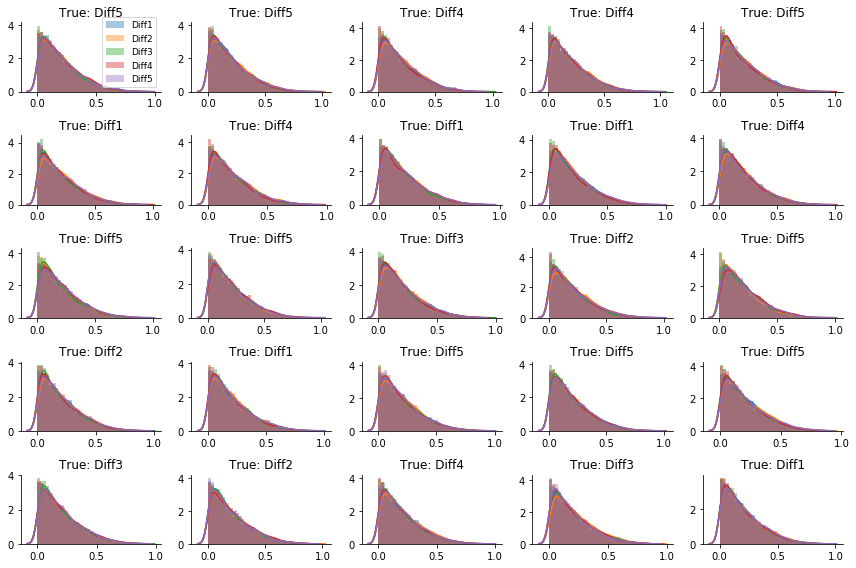

In [31]:
plot_dirichlet_samples(model, 
                       x_test=test_data['x'][:25], 
                       m_test=test_data['m'][:25], 
                       model_names=model_names,
                       figsize=(12, 8))

## Manage checkpoints

In [32]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


# Train network offline

In [50]:
# %%time
# for ep in range(1, epochs+1):
#     with tqdm(total=x.shape[0] // batch_size, desc='Training epoch {}'.format(ep)) as p_bar:
#         losses = train_offline(model=model, 
#                           optimizer=optimizer, 
#                           dataset=dataset, 
#                           loss_fun=risk, 
#                           batch_size=batch_size, 
#                           p_bar=p_bar, 
#                           clip_method='value', 
#                           global_step=global_step, 
#                           method='evidential')
        
        
#         # Plot stuff
#         plot_confusion_matrix(model, test_data['x'], test_data['m'], model_names, normalize=True)
#         plot_dirichlet_samples(model, 
#                        x_test=test_data['x'][:25], 
#                        m_test=test_data['m'][:25], 
#                        model_names=model_names,
#                        figsize=(12, 8))
#         m_pred = model(test_data['x'])['m_probs']
#         print(accuracy(test_data['m'], m_pred))

#         # Store checkpoint
#         manager.save()

## Validate evidential network

In [126]:
plot_dirichlet_samples(model, 
                   x_test=test_data['x'][:25], 
                   m_test=test_data['m'][:25], 
                   model_names=model_names,
                   figsize=(12, 8))

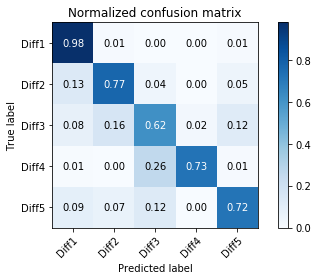

In [48]:
plot_confusion_matrix(model, test_data['x'], test_data['m'], model_names, normalize=True)

In [49]:
m_pred = model(test_data['x'])['m_probs']
print(accuracy(test_data['m'], m_pred))

0.761


In [52]:
param_priors = [model3_params_prior, 
                model3_params_prior, 
                model3_params_prior,
                model3_params_prior, 
                model3_params_prior]

forward_models = [forward_model1, 
                  forward_model2, 
                  forward_model3,
                  forward_model4, 
                  forward_model5]


data_gen_simple = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   n_obs=n_obs)

In [53]:
%%time
test_data_simple = data_gen_simple(n_test, to_tensor=True)

Wall time: 42.6 s


In [54]:
m_pred = model(test_data_simple['x'])['m_probs']

In [60]:
m_pred = model(test_data_simple['x'])['alpha']

In [62]:
m_pred = model(test_data_simple['x'])['m_probs']

In [63]:
m_pred

<tf.Tensor: id=256363808, shape=(1000, 5), dtype=float32, numpy=
array([[0.68551576, 0.07862106, 0.07862106, 0.07862106, 0.07862106],
       [0.96933967, 0.00766508, 0.00766508, 0.00766508, 0.00766508],
       [0.29700038, 0.17574991, 0.17574991, 0.17574991, 0.17574991],
       ...,
       [0.5776313 , 0.10559218, 0.10559218, 0.10559218, 0.10559218],
       [0.43148637, 0.14212841, 0.14212841, 0.14212841, 0.14212841],
       [0.8687502 , 0.03281245, 0.03281245, 0.03281245, 0.03281245]],
      dtype=float32)>

In [64]:
param_priors = [model3_params_prior, 
                model3_params_prior, 
                model3_params_prior,
                model3_params_prior, 
                model3_params_prior]

forward_models = [forward_model1, 
                  forward_model2, 
                  forward_model3,
                  forward_model4, 
                  forward_model5]


data_gen_diff3 = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   n_obs=n_obs)

In [68]:
%%time
test_data_diff3 = data_gen_diff3(n_test, to_tensor=True)

Wall time: 1min 27s


In [71]:
m_pred = model(test_data_diff3['x'])['alpha']

In [74]:
model(test_data_diff3['x'])['m_probs']

<tf.Tensor: id=256365866, shape=(1000, 5), dtype=float32, numpy=
array([[0.1824136 , 0.1824136 , 0.2703456 , 0.1824136 , 0.1824136 ],
       [0.17830211, 0.17830211, 0.28679156, 0.17830211, 0.17830211],
       [0.16573685, 0.16573685, 0.3370526 , 0.16573685, 0.16573685],
       ...,
       [0.19310604, 0.19310604, 0.20260958, 0.19310604, 0.21807225],
       [0.19156468, 0.19156468, 0.2337413 , 0.19156468, 0.19156468],
       [0.19130631, 0.23477475, 0.19130631, 0.19130631, 0.19130631]],
      dtype=float32)>

# Train with small regularization

In [138]:
#--- Training hyperparameters ---#
ckpt_file = "model_selection_diffusion_multiple_sreg"
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_obs = 500
n_test = 1000
n_train = 120000
annealing_step = 10000


#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.0005
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .99
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


#--- Generative model hyperparameters ---#

model_names = ['Diff1', 'Diff2', 'Diff3', 'Diff4', 'Diff5']

param_priors = [model1_params_prior, 
                model2_params_prior, 
                model3_params_prior,
                model4_params_prior, 
                model5_params_prior]

forward_models = [forward_model1, 
                  forward_model2, 
                  forward_model3,
                  forward_model4, 
                  forward_model5]


data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   n_obs=n_obs)


risk = partial(regularized_bayes_risk, global_step=global_step, annealing_step=annealing_step, max_lambda=0.01)

In [139]:
model = DeepEvidentialModel(INVARIANT_DIFFUSION, n_models=len(model_names))

In [140]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


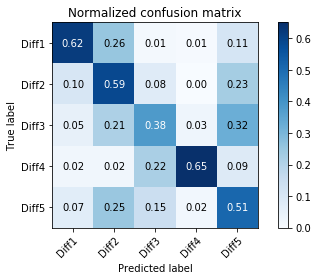

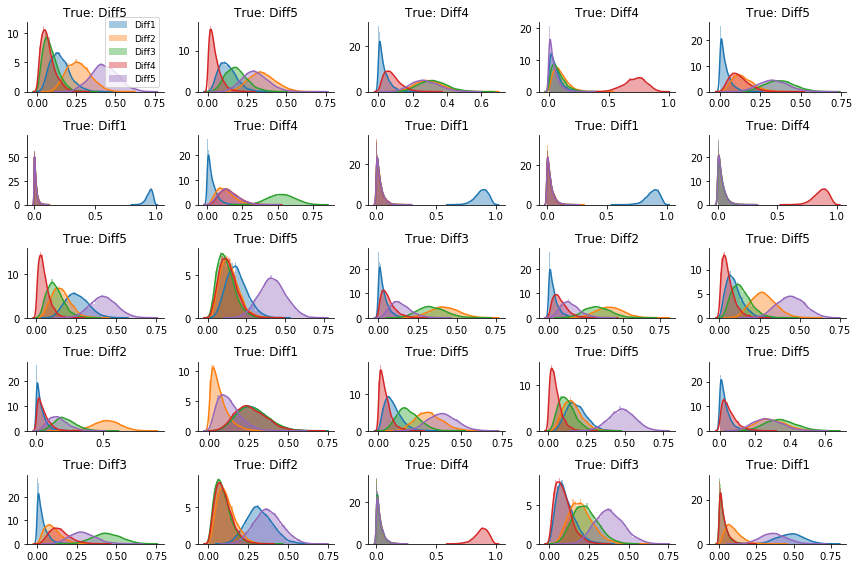

0.547



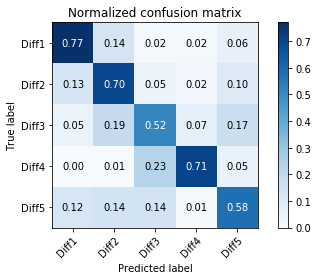

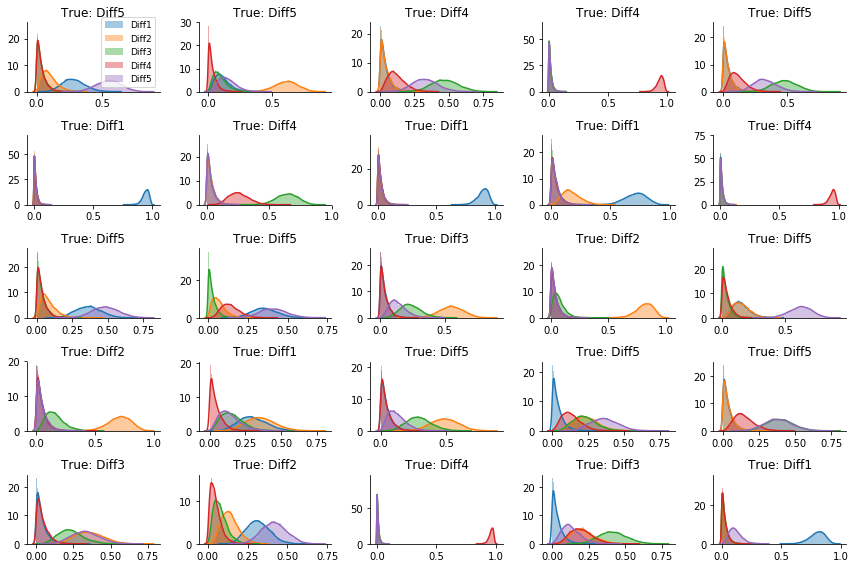

0.653



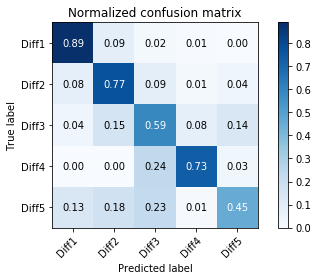

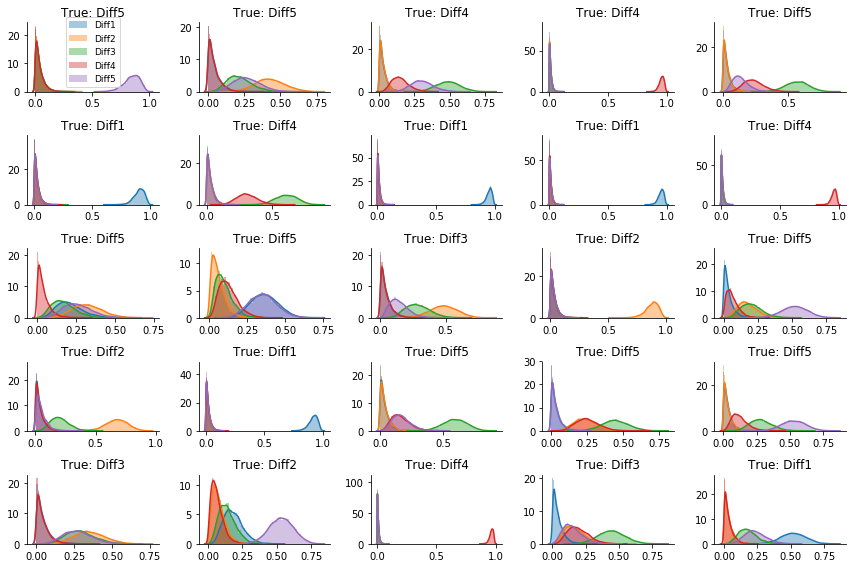

0.683



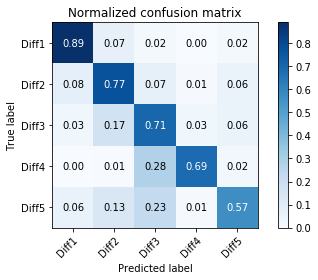

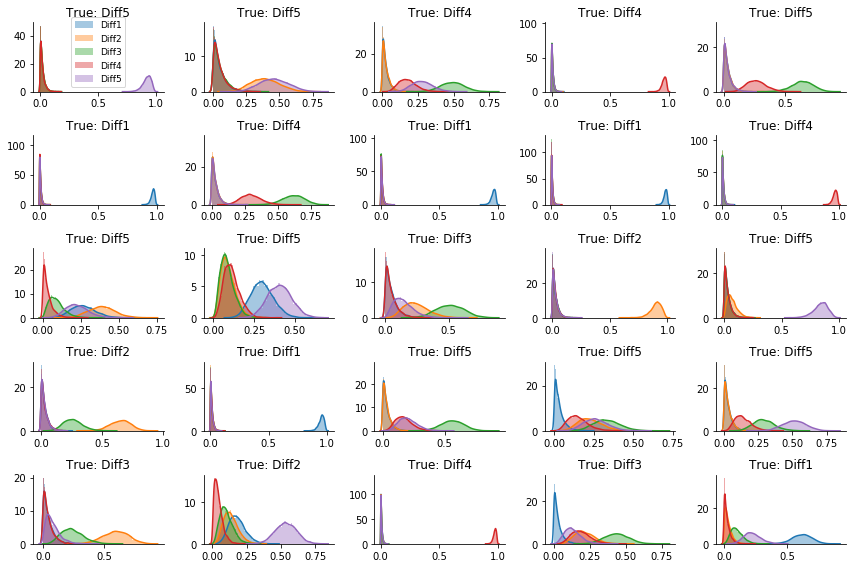

0.723



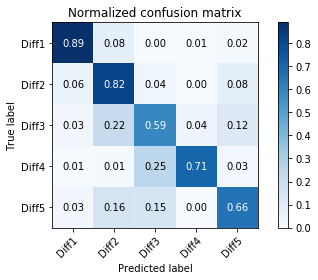

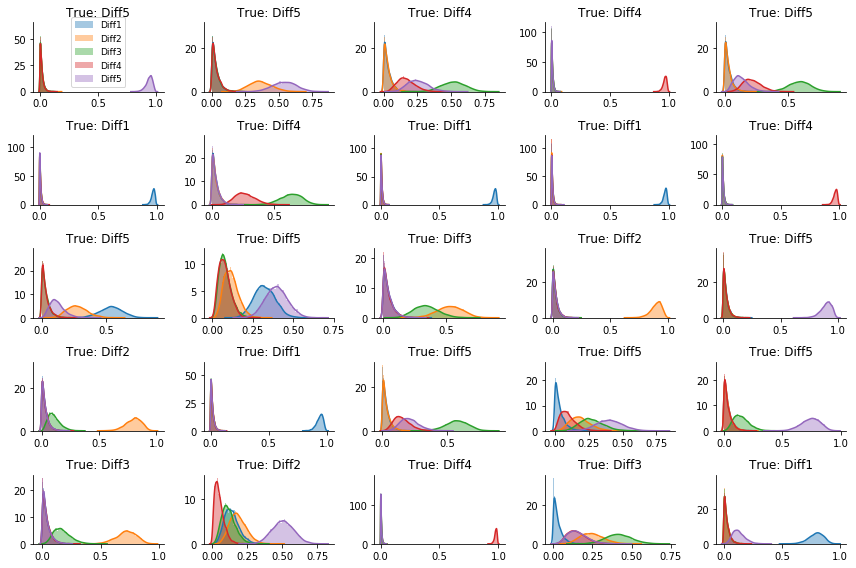

0.733



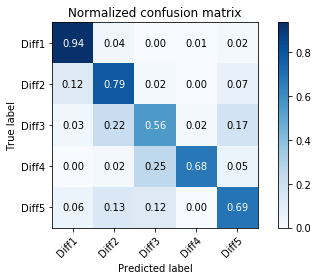

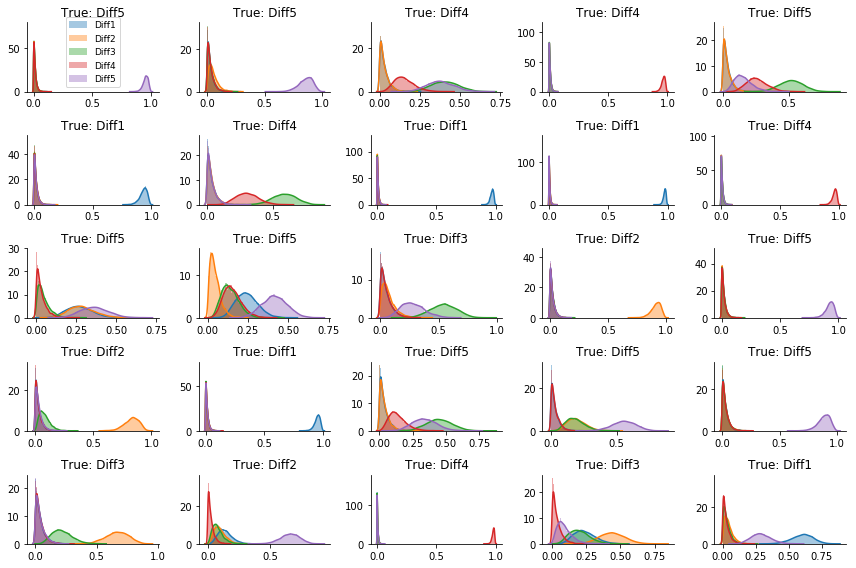

0.728



SystemError: <built-in function TFE_Py_TapeGradient> returned a result with an error set

In [142]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=x.shape[0] // batch_size, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_offline(model=model, 
                          optimizer=optimizer, 
                          dataset=dataset, 
                          loss_fun=risk, 
                          batch_size=batch_size, 
                          p_bar=p_bar, 
                          clip_method='value', 
                          global_step=global_step, 
                          method='evidential')
        
        
        # Plot stuff
        plot_confusion_matrix(model, test_data['x'], test_data['m'], model_names, normalize=True)
        plot_dirichlet_samples(model, 
                       x_test=test_data['x'][:25], 
                       m_test=test_data['m'][:25], 
                       model_names=model_names,
                       figsize=(12, 8))
        m_pred = model(test_data['x'])['m_probs']
        print(accuracy(test_data['m'], m_pred))

        # Store checkpoint
        manager.save()

## Validate

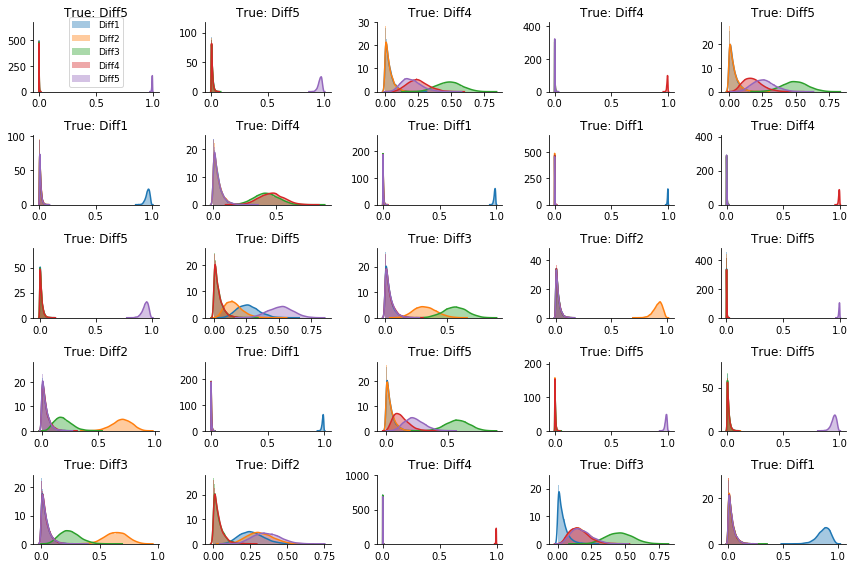

In [87]:
plot_dirichlet_samples(model, 
                   x_test=test_data['x'][:25], 
                   m_test=test_data['m'][:25], 
                   model_names=model_names,
                   figsize=(12, 8))

In [88]:
model(test_data_simple['x'])['m_probs'].numpy().mean(axis=0)

array([0.9045332 , 0.04191363, 0.01533379, 0.01370102, 0.02451854],
      dtype=float32)

In [89]:
model(test_data_diff3['x'])['m_probs'].numpy().mean(axis=0)

array([0.04335323, 0.17127842, 0.46055543, 0.15494153, 0.16987132],
      dtype=float32)

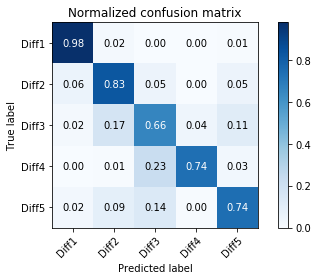

In [90]:
plot_confusion_matrix(model, test_data['x'], test_data['m'], model_names, normalize=True)

# Train with no regularization

In [130]:
#--- Training hyperparameters ---#
ckpt_file = "model_selection_diffusion_multiple_noreg"
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_obs = 500
n_test = 1000
n_train = 120000


#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.0005
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .99
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


#--- Generative model hyperparameters ---#

model_names = ['Diff1', 'Diff2', 'Diff3', 'Diff4', 'Diff5']

param_priors = [model1_params_prior, 
                model2_params_prior, 
                model3_params_prior,
                model4_params_prior, 
                model5_params_prior]

forward_models = [forward_model1, 
                  forward_model2, 
                  forward_model3,
                  forward_model4, 
                  forward_model5]


data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   n_obs=n_obs)

In [131]:
model = DeepEvidentialModel(INVARIANT_DIFFUSION, n_models=len(model_names))

In [132]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


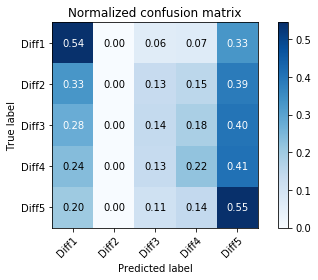

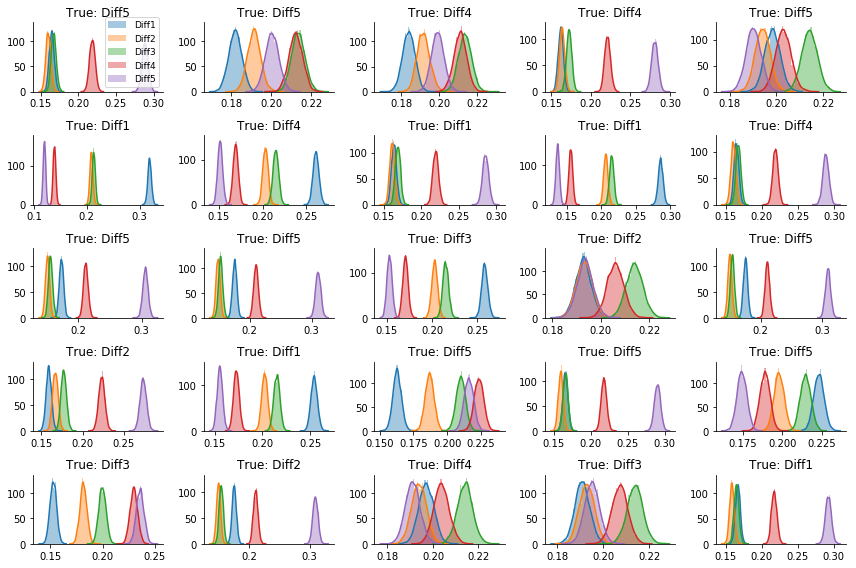

0.289



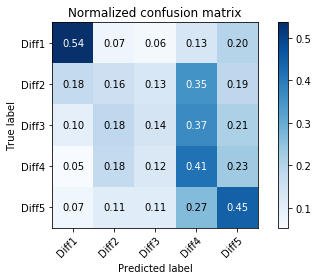

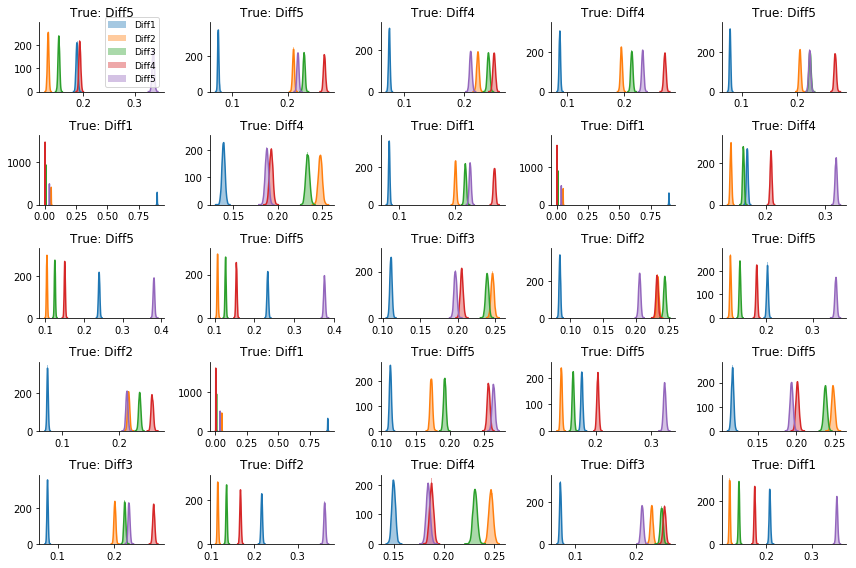

0.335



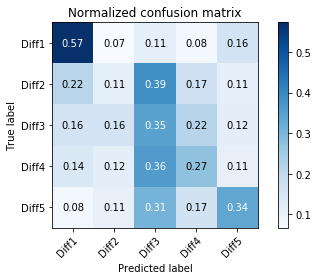

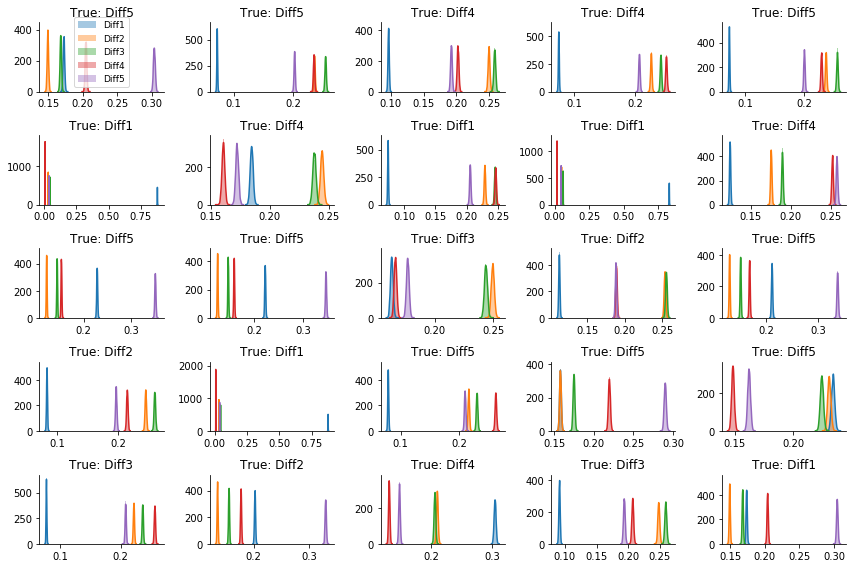

0.327



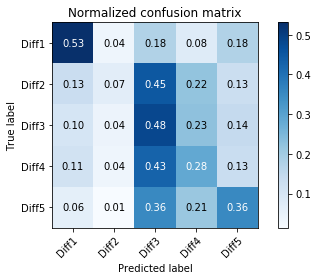

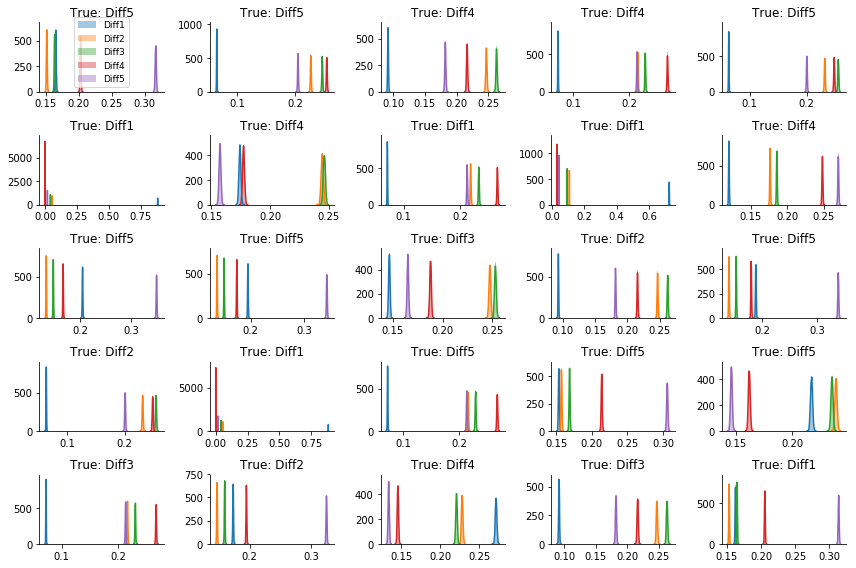

0.344



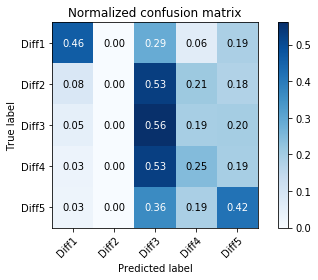

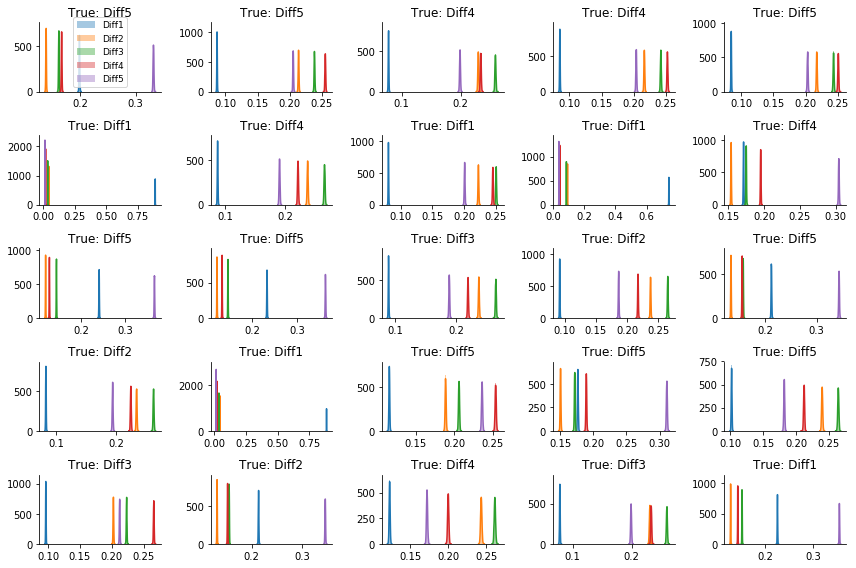

0.339



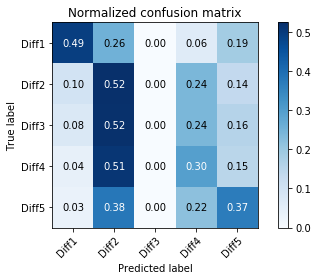

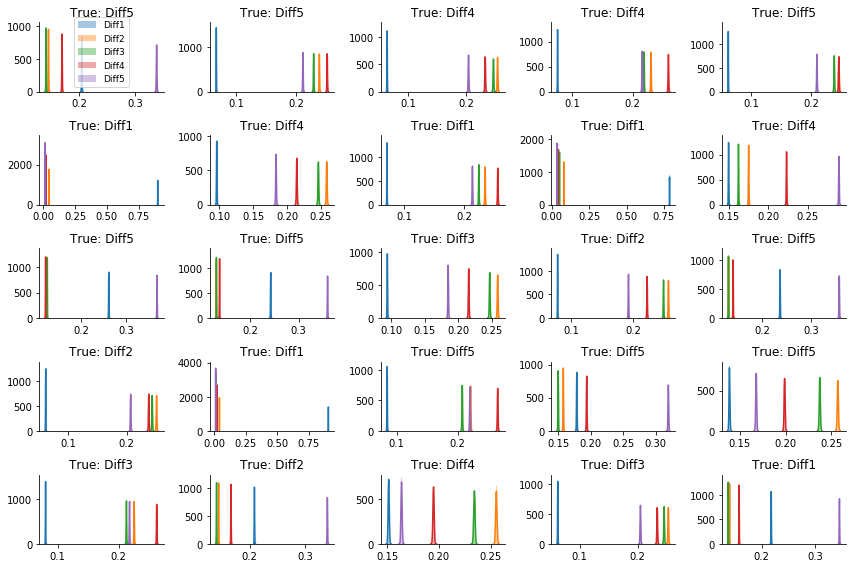

0.335



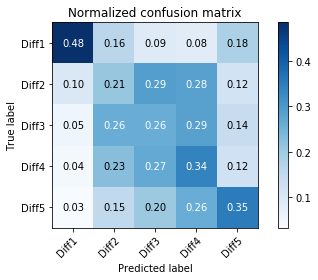

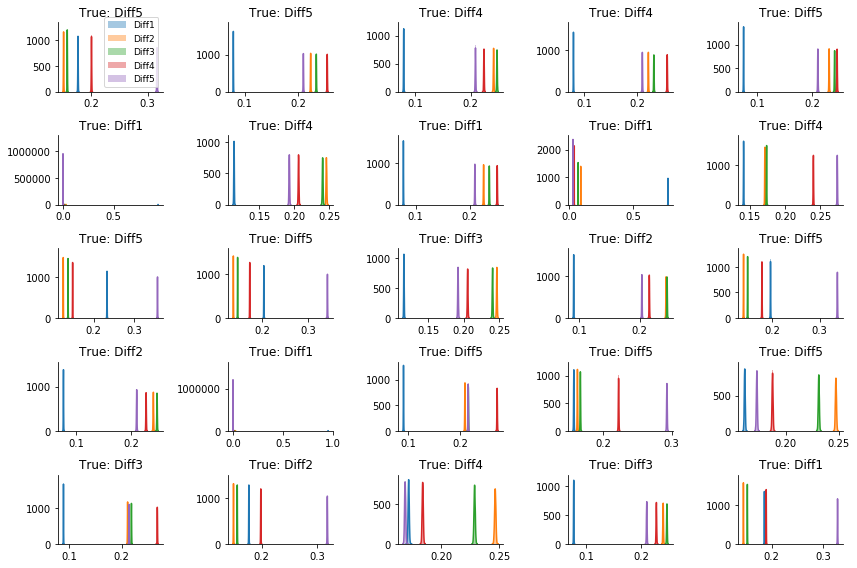

0.327



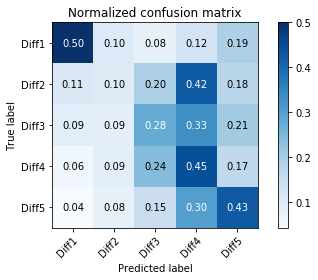

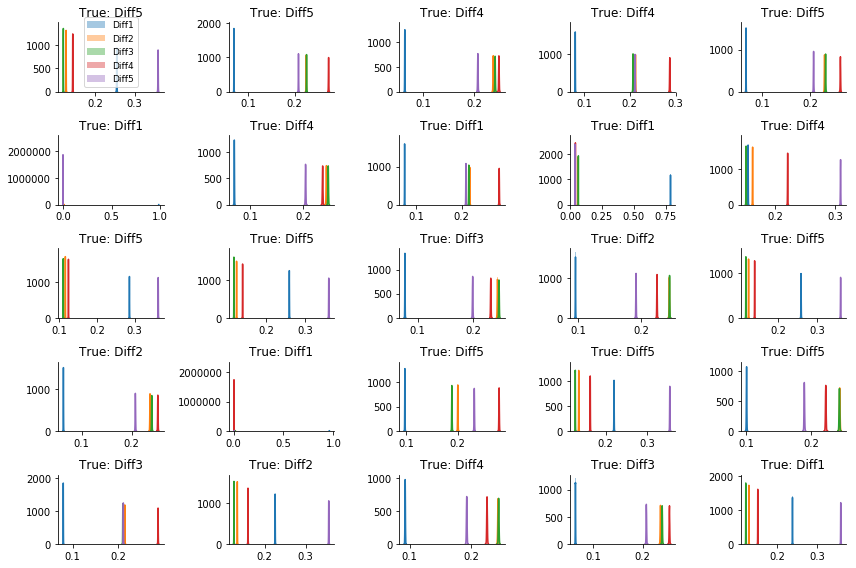

0.347



KeyboardInterrupt: 

In [133]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=x.shape[0] // batch_size, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_offline(model=model, 
                          optimizer=optimizer, 
                          dataset=dataset, 
                          loss_fun=bayes_risk, 
                          batch_size=batch_size, 
                          p_bar=p_bar, 
                          clip_method='value', 
                          global_step=global_step, 
                          method='evidential')
        
        
        # Plot stuff
        plot_confusion_matrix(model, test_data['x'], test_data['m'], model_names, normalize=True)
        plot_dirichlet_samples(model, 
                       x_test=test_data['x'][:25], 
                       m_test=test_data['m'][:25], 
                       model_names=model_names,
                       figsize=(12, 8))
        m_pred = model(test_data['x'])['m_probs']
        print(accuracy(test_data['m'], m_pred))

        # Store checkpoint
        manager.save()

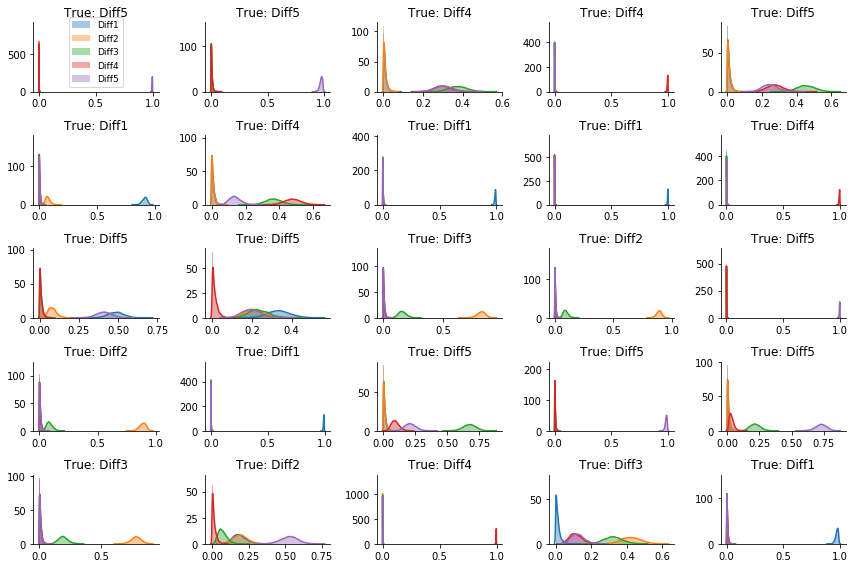

In [97]:
plot_dirichlet_samples(model, 
                   x_test=test_data['x'][:25], 
                   m_test=test_data['m'][:25], 
                   model_names=model_names,
                   figsize=(12, 8))

In [94]:
model(test_data_simple['x'])['m_probs'].numpy().mean(axis=0)

array([0.93940043, 0.04206274, 0.00722428, 0.00468556, 0.00662697],
      dtype=float32)

In [95]:
model(test_data_diff3['x'])['m_probs'].numpy().mean(axis=0)

array([0.02154925, 0.2099463 , 0.4199142 , 0.20008497, 0.1485053 ],
      dtype=float32)

# Train with different losses

In [110]:
def bayes_risk_cent(m_true, alpha, alpha0, m_probs):
    l = tf.reduce_sum(m_true * (tf.digamma(alpha0) - tf.digamma(alpha)), axis=1, keepdims=True)
    l = tf.reduce_mean(l)
    return l

def ml_dirichlet_loss(m_true, alpha, alpha0, m_probs):
    l = tf.reduce_sum(m_true * (tf.log(alpha0) - tf.log(alpha)), axis=1, keepdims=True)
    l = tf.reduce_mean(l)
    return l

## Cross-entropy loss

In [123]:
#--- Training hyperparameters ---#
ckpt_file = "model_selection_diffusion_multiple_cent"
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_obs = 500
n_test = 1000
n_train = 120000


#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.0005
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .99
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


#--- Generative model hyperparameters ---#

model_names = ['Diff1', 'Diff2', 'Diff3', 'Diff4', 'Diff5']

param_priors = [model1_params_prior, 
                model2_params_prior, 
                model3_params_prior,
                model4_params_prior, 
                model5_params_prior]

forward_models = [forward_model1, 
                  forward_model2, 
                  forward_model3,
                  forward_model4, 
                  forward_model5]


data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   n_obs=n_obs)

In [124]:
model = DeepEvidentialModel(INVARIANT_DIFFUSION, n_models=len(model_names))

In [125]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")

Initializing from scratch.


In [126]:
%%time
for ep in range(1, epochs+1):
    with tqdm(total=x.shape[0] // batch_size, desc='Training epoch {}'.format(ep)) as p_bar:
        losses = train_offline(model=model, 
                          optimizer=optimizer, 
                          dataset=dataset, 
                          loss_fun=ml_dirichlet_loss, 
                          batch_size=batch_size, 
                          p_bar=p_bar, 
                          clip_method='value', 
                          global_step=global_step, 
                          method='evidential')
        
        
        # Plot stuff
        plot_confusion_matrix(model, test_data['x'], test_data['m'], model_names, normalize=True)
        plot_dirichlet_samples(model, 
                       x_test=test_data['x'][:25], 
                       m_test=test_data['m'][:25], 
                       model_names=model_names,
                       figsize=(12, 8))
        m_pred = model(test_data['x'])['m_probs']
        print(accuracy(test_data['m'], m_pred))

        # Store checkpoint
        manager.save()

KeyboardInterrupt: 

In [106]:
model(test_data_simple['x'])['m_probs'].numpy().mean(axis=0)

array([0.8492143 , 0.09346209, 0.02427516, 0.00290778, 0.03014058],
      dtype=float32)

In [107]:
model(test_data_diff3['x'])['m_probs'].numpy().mean(axis=0)

array([0.02522301, 0.16461211, 0.4143064 , 0.21192764, 0.18393071],
      dtype=float32)

## Type 2

In [109]:
#--- Training hyperparameters ---#
ckpt_file = "model_selection_diffusion_multiple_type2"
batch_size = 64
epochs = 100
iterations_per_epoch = 1000
n_obs = 500
n_test = 1000
n_train = 120000


#--- Optimizer hyperparameters ---#
starter_learning_rate = 0.0005
global_step = tfe.Variable(0, dtype=tf.int32)
decay_steps = 1000
decay_rate = .99
learning_rate = tf.train.exponential_decay(starter_learning_rate, global_step, 
                                           decay_steps, decay_rate, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)


#--- Generative model hyperparameters ---#

model_names = ['Diff1', 'Diff2', 'Diff3', 'Diff4', 'Diff5']

param_priors = [model1_params_prior, 
                model2_params_prior, 
                model3_params_prior,
                model4_params_prior, 
                model5_params_prior]

forward_models = [forward_model1, 
                  forward_model2, 
                  forward_model3,
                  forward_model4, 
                  forward_model5]


data_gen = partial(data_generator, 
                   model_prior=model_prior, 
                   param_priors=param_priors,
                   forward_models=forward_models,
                   n_obs=n_obs)

In [ ]:
checkpoint = tf.train.Checkpoint(step=global_step, optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(checkpoint, './checkpoints/{}'.format(ckpt_file), max_to_keep=2)
checkpoint.restore(manager.latest_checkpoint)
if manager.latest_checkpoint:
    print("Restored from {}".format(manager.latest_checkpoint))
else:
    print("Initializing from scratch.")